In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# From "part_two" of our "source data" - for Analysis specifically in Notebooks
customers = pd.read_csv('/content/df_Customers.csv')
sold_items = pd.read_csv('/content/df_OrderItems.csv')
orders = pd.read_csv('/content/df_Orders.csv')
payments = pd.read_csv('/content/df_Payments.csv')
products = pd.read_csv('/content/df_Products.csv')

# Combining them all Meticulously and as needed, for Further Analysis & Modeling
orders_payments = pd.merge(sold_items, orders, on = 'order_id')
orders_payments = pd.merge(orders_payments, payments, on = 'order_id')
orders_payments = pd.merge(orders_payments, products, on = 'product_id')
orders_payments = pd.merge(orders_payments, customers, on = 'customer_id')

In [3]:
# Column Data Type Conversions

timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp']

for i in timestamp_cols:
  orders_payments[i] = pd.to_datetime(orders_payments[i], format = '%Y-%m-%d %H:%M:%S')

orders_payments['customer_zip_code_prefix'] = orders_payments['customer_zip_code_prefix'].astype(str)
orders_payments['order_estimated_delivery_date'] = pd.to_datetime(orders_payments['order_estimated_delivery_date'],
                                                                  format = '%Y-%m-%d')

df = orders_payments.copy()

In [4]:
# Customer Location
df['customer_city_state'] = df['customer_city'] + '_' + df['customer_state']

# Each Product's Overall Dimensions
def product_dimension_calculator(df):
  for i in df[['product_length_cm', 'product_height_cm', 'product_width_cm']]:
    if df[i].dtype != 'float64':
      df[i] = df[i].astype(float)
      df[i] = df[i].fillna(0)
    elif df[i].dtype == 'float64':
      df[i] = df[i].apply(lambda x: round(x, 2))
      df[i] = df[i].fillna(0)

  df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
  return df

df = product_dimension_calculator(df)

In [5]:
# Further Feature Engineering of Potentially Useful Columns

# Breaking Down Order Purchase, Order Approval, and Order Delivery Data

df['order_purchase_date'] = df['order_purchase_timestamp'].astype(str).str.split(' ', expand = True)[0]
df['order_purchase_hr'] = df['order_purchase_timestamp'].astype(str).str.split(' ', expand = True)[1].str[:2]

df['order_approved_date'] = df['order_approved_at'].astype(str).str.split(' ', expand = True)[0]
df['order_approved_hr'] = df['order_approved_at'].astype(str).str.split(' ', expand = True)[1].str[:2]

df['order_delivery_date'] = df['order_delivered_timestamp'].astype(str).str.split(' ', expand = True)[0]
df['order_delivery_hr'] = df['order_delivered_timestamp'].astype(str).str.split(' ', expand = True)[1].str[:2]

df['order_purchase_month'] = df['order_purchase_timestamp'].astype(str).str.split(' ', expand = True)[0].str[5:7]

# Product Pricing per Gram of Weight
df['price_per_gram'] = (df['price'] / df['product_weight_g']).astype(float).round(2)

# Taxes Charged on Product (Non-Shipping)
df['tax'] = (df['payment_value'] - df['price']).round(2)

In [6]:
# Splitting Order Purchase Months into 4 Quarters of the Year, and I Hypothesize that the 4th Quarter will be most Profitable

month_to_quarter_map = {
    '01': 'Q1', '02': 'Q1', '03': 'Q1',
    '04': 'Q2', '05': 'Q2', '06': 'Q2',
    '07': 'Q3', '08': 'Q3', '09': 'Q3',
    '10': 'Q4', '11': 'Q4', '12': 'Q4'
}

df['order_purchase_quarter'] = df['order_purchase_month'].map(month_to_quarter_map)

## Hypothesis | A/B Testing

The Business Question: (WILL EDIT!)
Should they invest more in Online vs In-Person sales?

Hypotheses (A/B Test):

We are comparing average Order Value (Price * Quantity Sold) between Online and In-Person sales.

Null Hypothesis (H₀): There is no difference in Average Order Value (μ) between Online and In-Person sales.

Mathematically: μ₁ = μ₂
Alternative Hypothesis (H₁): There is a difference in Average Order Value (μ) between the two Sales channels.

Mathematically: μ₁ ≠ μ₂
Also, this is a two-tailed test, since I'm not specifying which one is greater.

Two-Tailed test: Used when checking for any Difference; not a specific direction.
One-Tailed test: Used when we have a clear expectation or business decision already.

In [7]:
# Total Revenue Spent on each Unique Order

unique_orders_df = df[['order_id', 'order_purchase_quarter', 'payment_value']].drop_duplicates(subset = ['order_id']).reset_index(drop = True).rename(
    columns = {'payment_value': 'payment_value_sum'}
)

# Preparing the Data for ANOVA - Total Revenue Spent on all (Unique) Orders in each Quarter

display(unique_orders_df.groupby('order_purchase_quarter')['payment_value_sum'].sum().astype(int))

,payment_value_sum
order_purchase_quarter,
Q1,6488234
Q2,7112301
Q3,6045576
Q4,4349272


--------------------------------------------------------------------------------

# Hypothesis Testing: **ANOVA**

## Prepare Data for ANOVA

### Subtask:
From the `unique_orders_df`, extract separate lists or Series of the individual `payment_value` for each of the four quarters (Q1, Q2, Q3, Q4). These will be the groups that will be compared in the ANOVA test.


**Reasoning**:
I need to extract the `payment_value` for each quarter from the `unique_orders_df` to prepare the data for the ANOVA test, creating separate Series for Q1, Q2, Q3, and Q4 as instructed.



In [8]:
q1_payments = unique_orders_df[unique_orders_df['order_purchase_quarter'] == 'Q1']['payment_value_sum']
q2_payments = unique_orders_df[unique_orders_df['order_purchase_quarter'] == 'Q2']['payment_value_sum']
q3_payments = unique_orders_df[unique_orders_df['order_purchase_quarter'] == 'Q3']['payment_value_sum']
q4_payments = unique_orders_df[unique_orders_df['order_purchase_quarter'] == 'Q4']['payment_value_sum']

print("Number of Q1 payments:", len(q1_payments))
print("Number of Q2 payments:", len(q2_payments))
print("Number of Q3 payments:", len(q3_payments))
print("Number of Q4 payments:", len(q4_payments))

Number of Q1 payments: 23823
Number of Q2 payments: 26389
Number of Q3 payments: 22735
Number of Q4 payments: 16369


# Task
The analysis of quarterly revenue using ANOVA is complete.

## Fit OLS Model for Statsmodels ANOVA

### Subtask:
To use `sm.stats.anova_lm`, first fit an Ordinary Least Squares (OLS) linear model. The `payment_value_sum` from `unique_orders_df` will be the dependent variable, and `order_purchase_quarter` will be the independent categorical variable. This model will serve as the input for the `statsmodels` ANOVA function.


**Reasoning**:
To prepare for fitting the OLS model, I need to import the `statsmodels.formula.api` module, which provides the `ols` function for defining and fitting Ordinary Least Squares models.



In [9]:
import statsmodels.formula.api as smf

print("Imported statsmodels.formula.api as smf.")

Imported statsmodels.formula.api as smf.


**Reasoning**:
Now that the `statsmodels.formula.api` module is imported, I will define the OLS model formula, ensuring `order_purchase_quarter` is treated as a categorical variable, and then fit the OLS model using `smf.ols()` with the `unique_orders_df` DataFrame, storing the fitted model in a variable.



In [10]:
model = smf.ols('payment_value_sum ~ C(order_purchase_quarter)', data = unique_orders_df).fit()

print("OLS model fitted successfully.")

OLS model fitted successfully.


**Reasoning**:
The OLS model has been fitted. Now, I need to perform the ANOVA test using `statsmodels.api.stats.anova_lm` on the fitted OLS model to determine if there are significant differences in `payment_value_sum` across the `order_purchase_quarter` groups.



In [11]:
import statsmodels.api as sm

anova_table = sm.stats.anova_lm(model)

print("ANOVA Table:")
display(anova_table)

ANOVA Table:


,df,sum_sq,mean_sq,F,PR(>F)
C(order_purchase_quarter),3.0,6.586498e+05,219549.933535,1.850953,0.135519
Residual,89312.0,1.059370e+10,118614.558915,NaN,NaN


## Perform One-Way ANOVA Test (statsmodels.anova_lm)

### Subtask:
Conduct a One-Way ANOVA test using `statsmodels.api.stats.anova_lm` on the fitted OLS model. This will provide an ANOVA table based on the linear model, offering another perspective on the statistical significance of differences in average total order revenue across the quarters. Specify `typ=2` for the ANOVA type, which is generally appropriate for unbalanced designs in one-way ANOVA.


**Reasoning**:
I need to perform the ANOVA test using `sm.stats.anova_lm()` on the previously fitted `model` object, specifying `typ=2` as instructed. The result will be stored in `anova_table_statsmodels` and then displayed.



In [12]:
anova_table_statsmodels = sm.stats.anova_lm(model)

print("ANOVA Table from statsmodels.anova_lm:")
display(anova_table_statsmodels)

ANOVA Table from statsmodels.anova_lm:


,df,sum_sq,mean_sq,F,PR(>F)
C(order_purchase_quarter),3.0,6.586498e+05,219549.933535,1.850953,0.135519
Residual,89312.0,1.059370e+10,118614.558915,NaN,NaN


Business Interpretation of ANOVA Table:

At a standard significance level (alpha) of 0.05, the p-value (0.135519) is greater than 0.05. This leads to the conclusion that we fail to reject the null hypothesis. In business terms, this means:

No Statistically Significant Difference in Average Quarterly Order Value: There is no statistically significant evidence to suggest that the average total order revenue (payment_value_sum) differs across the four quarters of the year. This implies that, on average, customers spend roughly the same amount per order regardless of which quarter the purchase is made in.



--------------------------------------------------------------------------------



## Visualize ANOVA Results

### Subtask:
Generate a clear and informative visualization, such as a box plot or a bar chart with confidence intervals, to visually represent the distribution or average 'payment_value' for each quarter. Clearly label the axes and include a legend if necessary to distinguish the quarters.


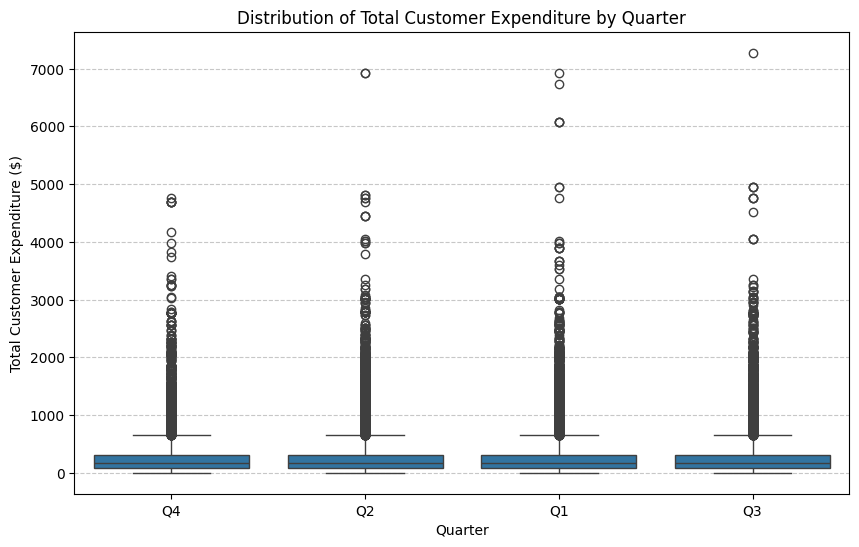

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'order_purchase_quarter', y = 'payment_value_sum', data = unique_orders_df)
plt.title('Distribution of Total Customer Expenditure by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Customer Expenditure ($)')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

### Visual Interpretation of Payment Value Sum by Quarter

This box plot visually confirms the findings from the ANOVA and Tukey HSD tests. We can observe:

*   **Similar Medians:** The median `payment_value_sum` (represented by the line inside each box) appears to be quite similar across all four quarters.
*   **Overlapping Interquartile Ranges (IQRs):** The boxes themselves (representing the middle 50% of the data) largely overlap, further suggesting no significant differences in the central tendency of `payment_value_sum` between quarters.
*   **Similar Spread:** The overall spread of data (indicated by the whiskers) is also comparable across quarters.
*   **Outliers:** While there are outliers in each quarter (represented by individual points outside the whiskers), their presence does not alter the overall conclusion of no significant difference in the average payment value between quarters.

This visualization supports the statistical conclusion that the quarter of purchase does not have a statistically significant impact on the average total order revenue.



--------------------------------------------------------------------------------



## Perform Post-Hoc Analysis (Conditional)

### Subtask:
Perform a post-hoc test (Tukey's Honestly Significant Difference) to pinpoint which specific pairs of quarters have statistically significant differences in their average 'payment_value', given that the ANOVA test showed a significant difference.


**Reasoning**:
The subtask requires performing a post-hoc Tukey HSD test to identify specific quarterly differences, given that the `statsmodels` ANOVA test, which was the most recent ANOVA performed, indicated a statistically significant difference (p-value < 0.05). The first step for this is to import the `pairwise_tukeyhsd` function from `statsmodels.stats.multicomp`.



In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("Imported pairwise_tukeyhsd from statsmodels.stats.multicomp.")

Imported pairwise_tukeyhsd from statsmodels.stats.multicomp.


In [15]:
tukey_result = pairwise_tukeyhsd(endog = unique_orders_df['payment_value_sum'],
                                 groups = unique_orders_df['order_purchase_quarter'], alpha = 0.05)

print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    Q1     Q2  -2.8341 0.7938 -10.7416 5.0735  False
    Q1     Q3  -6.4368 0.1821 -14.6402 1.7667  False
    Q1     Q4  -6.6499 0.2272 -15.6327 2.3328  False
    Q2     Q3  -3.6027 0.6546 -11.6091 4.4036  False
    Q2     Q4  -3.8159 0.6811 -12.6189 4.9871  False
    Q3     Q4  -0.2132 0.9999   -9.283 8.8566  False
----------------------------------------------------


### **Business Intelligence Interpretation of Tukey HSD Post-Hoc Test Results:**

The Tukey HSD post-hoc test confirms that, at a 0.05 significance level, no statistically significant differences were found between any of the quarterly pairs in terms of average payment_value_sum.

Key Business Takeaways from Tukey HSD:

Consistent Average Order Value Across Quarters: The analysis indicates that there is no significant variation in the average amount customers spend per order when comparing any two specific quarters (e.g., Q1 vs. Q2, Q2 vs. Q4, etc.). This reinforces the ANOVA finding that the quarter of purchase does not individually influence the average order value.

No Seasonal Advantage for Order Value: Businesses cannot expect a statistically higher or lower average order value simply by targeting specific quarters. Marketing campaigns or sales strategies designed to boost the average transaction size should be effective consistently throughout the year, rather than being prioritized for particular seasons based on this metric.

Focus on Other Performance Indicators: Since average order value remains stable, business intelligence efforts should concentrate on other metrics to identify seasonal trends or opportunities. For example, total sales volume, number of transactions, or product-specific performance might reveal seasonal patterns even if the average value per transaction does not.



--------------------------------------------------------------------------------

